# Connect to database

In [162]:
import geopandas as gpd
import pandas as pd

import psycopg2
import psycopg2.extras
from sqlalchemy import create_engine, text
import json
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt


credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            conn.execute(text("SELECT 1"))
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result


db, conn = pgconnect(credentials)

query(conn, "select postgis_version()")





Connected successfully.


,postgis_version
0,3.4 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


# Import datasets (Task 1)

In [ ]:
def create_wkt_element(geom, srid):
    if geom is None:
        return None
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])

    return WKTElement(geom.wkt, srid)

# Businesses.csv
businesses_df = pd.read_csv('Datasets/Businesses.csv')
businesses_df = businesses_df.rename(columns={col: col.lower() for col in businesses_df.columns})

# Income.csv
income_df = pd.read_csv('Datasets/Income.csv')
income_df = income_df.rename(columns={col: col.lower() for col in businesses_df.columns})

# PollingPlaces2019.csv
polling_places_df = pd.read_csv('Datasets/PollingPlaces2019.csv')
polling_places_df['geom'] = gpd.points_from_xy(polling_places_df.longitude, polling_places_df.latitude)
polling_places_df = polling_places_df.drop(columns=['latitude', 'longitude', 'the_geom'])
srid = 4326
polling_places_df['geom'] = polling_places_df['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
polling_places_df = polling_places_df.rename(columns={col: col.lower() for col in polling_places_df.columns})

# Population.csv
population_df = pd.read_csv('Datasets/Population.csv')
population_df = population_df.rename(columns={col: col.lower() for col in population_df.columns})

# Stops.txt
stops_df = pd.read_csv('Datasets/Stops.txt')
stops_df['geom'] = gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat)
stops_df = stops_df.drop(columns=['stop_lat', 'stop_lon'])
srid = 4326
stops_df['geom'] = stops_df['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
stops_df = stops_df.rename(columns={col: col.lower() for col in stops_df.columns})


#SA2 regions shapefile
sa2_regions = gpd.read_file("Datasets/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
sa2_og = sa2_regions.copy()  # creating a copy of the original for later
sa2_regions['geom'] = sa2_regions['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4326))  # applying the function
sa2_regions = sa2_regions.drop(columns="geometry")  # deleting the old copy
sa2_regions = sa2_regions.rename(columns={col: col.lower() for col in sa2_regions.columns})


# catchments_future Shapefile
catchments_future = gpd.read_file('Datasets/catchments/catchments_future.shp')
catchments_future = catchments_future.to_crs(epsg=4326)

# catchments_primary Shapefile
catchments_primary = gpd.read_file('Datasets/catchments/catchments_primary.shp')
catchments_primary = catchments_primary.to_crs(epsg=4326)

# catchments_secondary Shapefile
catchments_secondary = gpd.read_file('Datasets/catchments/catchments_secondary.shp')
catchments_secondary = catchments_secondary.to_crs(epsg=4326)

# Combined school catchments
schools_df = pd.concat([catchments_future, catchments_primary, catchments_secondary], ignore_index=True)
schools_og = schools_df.copy() # creating a copy of the original for later
schools_df['geom'] = schools_df['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=4326))  # applying the function
schools_df = schools_df.drop(columns="geometry")  # deleting the old copy
schools_df = schools_df.rename(columns={col: col.lower() for col in schools_df.columns})


# Clean datasets (Task 1)

### Change the column data types of each table

In [124]:
businesses_df['sa2_code'] = businesses_df['sa2_code'].astype(str)

polling_places_df['polling_place_id'] = polling_places_df['polling_place_id'].astype(str)
polling_places_df['division_id'] = polling_places_df['division_id'].astype(str)
polling_places_df['polling_place_type_id'] = polling_places_df['polling_place_type_id'].astype(str)
polling_places_df['premises_post_code'] = polling_places_df['premises_post_code'].astype(str)

population_df['sa2_code'] = population_df['sa2_code'].astype(str)

income_df['sa2_code21'] = income_df['sa2_code21'].astype(str)
income_df['earners'] = pd.to_numeric(income_df['earners'], errors='coerce')
income_df['median_age'] = pd.to_numeric(income_df['median_age'], errors='coerce')
income_df['median_income'] = pd.to_numeric(income_df['median_income'], errors='coerce')
income_df['mean_income'] = pd.to_numeric(income_df['mean_income'], errors='coerce')

### Print null values of each table

In [125]:
print("businesses_df null values:")
print(businesses_df.isnull().sum())

print("\nstops_df null values:")
print(stops_df.isnull().sum())

print("\npolling_places_df null values:")
print(polling_places_df.isnull().sum())

print("\npopulation_df null values:")
print(population_df.isnull().sum())

print("\nincome_df null values:")
print(income_df.isnull().sum())

print("\nschools_df null values:")
print(schools_df.isnull().sum())

print("\nsa2_regions null values:")
print(sa2_regions.isnull().sum())

businesses_df null values:
industry_code             0
industry_name             0
sa2_code                  0
sa2_name                  0
0_to_50k_businesses       0
50k_to_200k_businesses    0
200k_to_2m_businesses     0
2m_to_5m_businesses       0
5m_to_10m_businesses      0
10m_or_more_businesses    0
total_businesses          0
dtype: int64

stops_df null values:
stop_id                     0
stop_code               53999
stop_name                   0
location_type           60727
parent_station          53991
wheelchair_boarding         0
platform_code          113847
geom                        0
dtype: int64

polling_places_df null values:
fid                               0
state                             0
division_id                       0
division_name                     0
polling_place_id                  0
polling_place_type_id             0
polling_place_name                0
premises_name                     0
premises_address_1              193
premises_address_2  

### Fill the null values by median or mode

In [126]:
# fill null values
stops_df['stop_code'] = stops_df['stop_code'].fillna(stops_df['stop_code'].median())
stops_df['location_type'] = stops_df['location_type'].fillna(stops_df['location_type'].median())
stops_df['parent_station'] = stops_df['parent_station'].fillna(stops_df['parent_station'].mode()[0])
stops_df['platform_code'] = stops_df['platform_code'].fillna(stops_df['platform_code'].mode()[0])

polling_places_df['premises_address_1'] = polling_places_df['premises_address_1'].fillna(polling_places_df['premises_address_1'].mode()[0])
polling_places_df['premises_address_2'] = polling_places_df['premises_address_2'].fillna(polling_places_df['premises_address_2'].mode()[0])
polling_places_df['premises_address_3'] = polling_places_df['premises_address_3'].fillna(polling_places_df['premises_address_3'].mode()[0])
polling_places_df['premises_suburb'] = polling_places_df['premises_suburb'].fillna(polling_places_df['premises_suburb'].mode()[0])
polling_places_df['geom'] = polling_places_df['geom'].fillna(polling_places_df['geom'].mode()[0])

income_df['earners'] = income_df['earners'].fillna(income_df['earners'].median())
income_df['median_age'] = income_df['median_age'].fillna(income_df['median_age'].median())
income_df['median_income'] = income_df['median_income'].fillna(income_df['median_income'].median())
income_df['mean_income'] = income_df['mean_income'].fillna(income_df['mean_income'].median())

schools_df['add_date'] = schools_df['add_date'].fillna(schools_df['add_date'].mode()[0])
schools_df['priority'] = schools_df['priority'].fillna(schools_df['priority'].mode()[0])

sa2_regions['areasqkm21'] = sa2_regions['areasqkm21'].fillna(sa2_regions['areasqkm21'].median())
sa2_regions = sa2_regions.dropna(subset=['geom'])


# Check if there still exists null values
print("stops_df null values:")
print(stops_df.isnull().sum())

print("\npolling_places_df null values:")
print(polling_places_df.isnull().sum())

print("\nincome_df null values:")
print(income_df.isnull().sum())

print("\nschools_df null values:")
print(schools_df.isnull().sum())

print("\nsa2_regions null values:")
print(sa2_regions.isnull().sum())

stops_df null values:
stop_id                0
stop_code              0
stop_name              0
location_type          0
parent_station         0
wheelchair_boarding    0
platform_code          0
geom                   0
dtype: int64

polling_places_df null values:
fid                            0
state                          0
division_id                    0
division_name                  0
polling_place_id               0
polling_place_type_id          0
polling_place_name             0
premises_name                  0
premises_address_1             0
premises_address_2             0
premises_address_3             0
premises_suburb                0
premises_state_abbreviation    0
premises_post_code             0
geom                           0
dtype: int64

income_df null values:
sa2_code21       0
sa2_name         0
earners          0
median_age       0
median_income    0
mean_income      0
dtype: int64

schools_df null values:
use_id        0
catch_type    0
use_desc      0
a

### Check the duplicates

In [127]:
print("businesses_df duplicate values:", businesses_df.duplicated().sum())
print("stops_df duplicate values:", stops_df.duplicated().sum())
print("polling_places_df duplicate values:", polling_places_df.duplicated().sum())
print("population_df duplicate values:", population_df.duplicated().sum())
print("income_df duplicate values:", income_df.duplicated().sum())
print("schools_df duplicate values:", schools_df.duplicated().sum())
print("sa2_regions duplicate values:", sa2_regions.duplicated().sum())

businesses_df duplicate values: 0
stops_df duplicate values: 0
polling_places_df duplicate values: 0
population_df duplicate values: 0
income_df duplicate values: 0
schools_df duplicate values: 0
sa2_regions duplicate values: 0


# Create tables (Task 1)

In [130]:
conn.execute(text("""
DROP TABLE IF EXISTS businesses;
CREATE TABLE businesses (
    industry_code VARCHAR(80),
    industry_name VARCHAR(80),
    sa2_code INT,
    sa2_name VARCHAR(80),
    "0_to_50k_businesses" INT,
    "50k_to_200k_businesses" INT,
    "200k_to_2m_businesses" INT,
    "2m_to_5m_businesses" INT,
    "5m_to_10m_businesses" INT,
    "10m_or_more_businesses" INT,
    total_businesses INT
);
ALTER TABLE businesses
ADD CONSTRAINT businesses_pkey PRIMARY KEY (industry_code, sa2_code);
"""))
conn.commit()

businesses_df.to_sql('businesses', conn, if_exists='replace', index=False)
query(conn, "select * from businesses")


,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9


In [133]:
conn.execute(text("""
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code21 INT,
    sa2_name VARCHAR(80),
    earners INT,
    median_age FLOAT,
    median_income FLOAT,
    mean_income FLOAT
);
ALTER TABLE income
ADD CONSTRAINT income_pkey PRIMARY KEY (sa2_name);             
"""))

conn.commit()

income_df.to_sql('income', conn, if_exists='replace', index=False)
query(conn, "select * from income")

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467.0,51.0,46640.0,68904.0
1,101021008,Karabar,5103.0,42.0,65564.0,69672.0
2,101021009,Queanbeyan,7028.0,39.0,63528.0,69174.0
3,101021010,Queanbeyan - East,3398.0,39.0,66148.0,74162.0
4,101021012,Queanbeyan West - Jerrabomberra,8422.0,44.0,78630.0,91981.0
...,...,...,...,...,...,...
637,128021537,Royal National Park,14.0,37.0,36980.0,47584.0
638,128021538,Sutherland - Kirrawee,13895.0,41.0,64940.0,74867.0
639,128021607,Engadine,10239.0,43.0,63695.0,72995.0
640,128021608,Loftus - Yarrawarrah,4424.0,45.0,63087.0,76440.0


In [134]:
conn.execute(text("""
DROP TABLE IF EXISTS polling_places;
CREATE TABLE polling_places (
    fid VARCHAR(80),
    state VARCHAR(80),
    division_id INT,
    division_name VARCHAR(80),
    polling_place_id INT,
    polling_place_type_id INT,
    polling_place_name VARCHAR(80),
    premises_name VARCHAR(80),
    premises_address_1 VARCHAR(255),
    premises_address_2 VARCHAR(255),
    premises_address_3 VARCHAR(255),
    premises_suburb VARCHAR(80),
    premises_state_abbreviation VARCHAR(80),
    premises_post_code FLOAT,
    latitude FLOAT,
    longitude FLOAT,
    the_geom GEOMETRY(POINT, 4326)
);
ALTER TABLE polling_places
ADD CONSTRAINT polling_places_pkey PRIMARY KEY (polling_place_id);               
"""))
conn.commit()

polling_places_df.to_sql('polling_places', conn, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from polling_places")

,fid,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,George St,Ground Floor,Former Coach Terminal,SYDNEY,NSW,nan,0101000020E6100000000000000000F87F000000000000...
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,George St,Ground Floor,Former Coach Terminal,SYDNEY,NSW,nan,0101000020E6100000000000000000F87F000000000000...
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,George St,Ground Floor,Former Coach Terminal,SYDNEY,NSW,nan,0101000020E6100000000000000000F87F000000000000...
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,George St,Ground Floor,Former Coach Terminal,ORANGE,NSW,2800.0,0101000020E6100000000000000000F87F000000000000...
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,George St,Ground Floor,Former Coach Terminal,SYDNEY,NSW,nan,0101000020E6100000000000000000F87F000000000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,Ground Floor,Former Coach Terminal,BARRACK HEIGHTS,NSW,2528.0,0101000020E6100000FA7E6ABC74DB62409C33A2B43748...
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,George St,Ground Floor,Former Coach Terminal,WARILLA,NSW,2528.0,0101000020E6100000BD32141C83DB624011F28B5C8146...
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,Ground Floor,Former Coach Terminal,WELBY,NSW,2575.0,0101000020E610000021B0726891CD6240386744696F38...
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,Ground Floor,Former Coach Terminal,WINDANG,NSW,2528.0,0101000020E6100000C1CAA145B6DB6240DC4603780B44...


In [138]:
conn.execute(text("""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code INT,
    sa2_name VARCHAR(80),
    "0-4_people" INT,
    "5-9_people" INT,
    "10-14_people" INT,
    "15-19_people" INT,
    "20-24_people" INT,
    "25-29_people" INT,
    "30-34_people" INT,
    "35-39_people" INT,
    "40-44_people" INT,
    "45-49_people" INT,
    "50-54_people" INT,
    "55-59_people" INT,
    "60-64_people" INT,
    "65-69_people" INT,
    "70-74_people" INT,
    "75-79_people" INT,
    "80-84_people" INT,
    "85-and-over_people" INT,
    total_people INT
);
ALTER TABLE population
ADD CONSTRAINT population_pkey PRIMARY KEY (sa2_code);                 
"""))
conn.commit()

population_df.to_sql('population', conn, if_exists='replace', index=False)
query(conn, "select * from population")

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


In [139]:
conn.execute(text("""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    stop_id VARCHAR(80),
    stop_code FLOAT,
    stop_name VARCHAR(255),
    stop_lat FLOAT,
    stop_lon FLOAT,
    location_type FLOAT,
    parent_station VARCHAR(80),
    wheelchair_boarding INT,
    platform_code VARCHAR(80),
    the_geom GEOMETRY(POINT, 4326)
);
ALTER TABLE stops
ADD CONSTRAINT stops_pkey PRIMARY KEY (stop_id);                  
"""))
conn.commit()

stops_df.to_sql('stops', conn, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from stops")

,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",1.0,200060,0,1,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,200054.0,"Central Station, Eddy Av, Stand D",1.0,200060,0,1,0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,2142172.0,Central Station,1.0,200060,0,1,0101000020E6100000817FA2F299E662408FF33DAC29F1...
3,201510,2142172.0,Redfern Station,1.0,200060,0,1,0101000020E61000009E57611C5DE6624060304CE622F2...
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",1.0,201510,0,1,0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",1.0,21271,1,B,0101000020E6100000AF9B3D8185E262408F52D7D537E9...
114714,2137185,2137185.0,"Cabarita Wharf, Side A",1.0,21371,1,1A,0101000020E6100000EB409ADCBDE3624089CE4C0B9BEB...
114715,2137186,2137186.0,"Cabarita Wharf, Side B",1.0,21371,1,1B,0101000020E6100000C4F9BEA2BDE362403EB375529EEB...
114716,21501,21501.0,Parramatta Wharf,1.0,2150112,1,1,0101000020E6100000E443E4A456E0624025C1A4032EE8...


In [142]:
conn.execute(text("""
DROP TABLE IF EXISTS regions;
CREATE TABLE regions (
    sa2_code21 VARCHAR(80), 
    sa2_name21 VARCHAR(80),  
    chg_flag21 VARCHAR(80), 
    chg_lbl21 VARCHAR(80), 
    sa3_code21 VARCHAR(80), 
    sa3_name21 VARCHAR(80), 
    sa4_code21 VARCHAR(80), 
    sa4_name21 VARCHAR(80), 
    gcc_code21 VARCHAR(80), 
    gcc_name21 VARCHAR(80), 
    ste_code21 VARCHAR(80), 
    ste_name21 VARCHAR(80), 
    aus_code21 VARCHAR(80), 
    aus_name21 VARCHAR(80), 
    areasqkm21 VARCHAR(80), 
    loci_uri21 VARCHAR(80),
    geom GEOMETRY(MULTIPOLYGON,4326)
);
ALTER TABLE regions
ADD CONSTRAINT regions_pkey PRIMARY KEY (sa2_code21);                 
""")
)

conn.commit()

sa2_regions.to_sql("regions", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})
query(conn, "select * from regions")






,sa2_code21,sa2_name21,chg_flag21,chg_lbl21,sa3_code21,sa3_name21,sa4_code21,sa4_name21,gcc_code21,gcc_name21,ste_code21,ste_name21,aus_code21,aus_name21,areasqkm21,loci_uri21,geom
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E6100000010000000103000000010000005D...
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E6100000010000000103000000010000002C...
2,101021610,Googong,1,New,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9164,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E6100000010000000103000000010000006D...
3,101021611,Queanbeyan Surrounds,1,New,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3047.7057,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000200000041...
4,101031013,Bombala,0,No change,10103,Snowy Mountains,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3990.144,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000031...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,801111141,Namadgi,0,No change,80111,Uriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,AUS,Australia,1202.7527,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E6100000010000000103000000010000004B...
2450,901011001,Christmas Island,0,No change,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,136.1356,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000094...
2451,901021002,Cocos (Keeling) Islands,0,No change,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,13.7258,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E610000038000000010300000001000000CF...
2452,901031003,Jervis Bay,0,No change,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,67.2296,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000300000001030000000100000016...


In [143]:
conn.execute(text("""
DROP TABLE IF EXISTS schools;
CREATE TABLE schools (
    use_id VARCHAR(80), 
    catch_type VARCHAR(80),  
    use_desc VARCHAR(80), 
    add_date VARCHAR(80), 
    kindergart VARCHAR(80), 
    year1 VARCHAR(80), 
    year2 VARCHAR(80), 
    year3 VARCHAR(80),
    year4 VARCHAR(80), 
    year5 VARCHAR(80), 
    year6 VARCHAR(80),
    year7 VARCHAR(80), 
    year8 VARCHAR(80), 
    year9 VARCHAR(80),
    year10 VARCHAR(80), 
    year11 VARCHAR(80), 
    year12 VARCHAR(80),
    priority VARCHAR(80),                
    geom GEOMETRY(MULTIPOLYGON,4326)
);
ALTER TABLE schools
ADD CONSTRAINT schools_pkey PRIMARY KEY (use_id);                  
""")
)

conn.commit()

schools_df = schools_df.drop_duplicates(subset=['use_id'])
schools_df.to_sql("schools", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})
query(conn, "select * from schools")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,N,0106000020E61000000100000001030000000100000090...
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,N,0106000020E6100000010000000103000000010000006F...
2,1839,PRIMARY,Empire Bay PS,20211115,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,0106000020E61000000100000001030000000100000032...
3,1659,PRIMARY,Corowa SPS,20200404,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,0106000020E61000000100000001030000000100000007...
4,4581,PRIMARY,Frank Partridge VC PS,20220614,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,0106000020E61000000100000001030000000100000038...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,8468,HIGH_COED,Mulwaree HS,20220619,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,N,0106000020E610000001000000010300000001000000F0...
2031,8561,HIGH_COED,Shoalhaven HS,20220619,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,N,0106000020E610000001000000010300000001000000B3...
2032,8593,HIGH_COED,Vincentia HS,20220619,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,N,0106000020E610000001000000010300000001000000E1...
2033,8213,HIGH_BOYS,Birrong BHS,20211221,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,N,0106000020E61000000100000001030000000100000040...


# Calucute part(task 2)

In [144]:
# Create business_population table
sql = """
DROP TABLE IF EXISTS business_population;
CREATE TABLE business_population AS 
SELECT b.sa2_code, p.total_people, b.total_businesses
FROM businesses AS b 
INNER JOIN population AS p 
ON b.sa2_code = p.sa2_code
WHERE b.industry_code IN ('F', 'G', 'H', 'I')
AND p.total_people > 100;
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [145]:
# Create z-score for business
sql = """
DROP VIEW IF EXISTS zscore_business;
CREATE VIEW zscore_business AS (
    WITH subquery AS (
        SELECT sa2_code, total_businesses::NUMERIC / total_people::NUMERIC * 1000 AS business_pop_ratio
        FROM business_population
    )
    SELECT sa2_code, 
           (business_pop_ratio - AVG(business_pop_ratio) OVER ()) / (STDDEV(business_pop_ratio) OVER ()) AS z_score_business
    FROM subquery
);
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [148]:
# Create stops_count table
sql = """
DROP TABLE IF EXISTS stops_count;
CREATE TABLE stops_count AS 
SELECT a.sa2_code21 AS sa2_code, a.sa2_name21 AS sa2_region, COUNT(s.stop_id) AS count
FROM regions a 
JOIN stops s 
ON ST_Within(s.geom, a.geom)
GROUP BY a.sa2_code21, a.sa2_name21;
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [149]:
# Create z-score for stops
sql = """
DROP VIEW IF EXISTS zscore_stops;
CREATE VIEW zscore_stops AS (
    WITH subquery AS (
        SELECT sa2_code, count::NUMERIC AS counts
        FROM stops_count
    )
    SELECT sa2_code, 
           (counts - AVG(counts) OVER ()) / (STDDEV(counts) OVER ()) AS z_score_stops
    FROM subquery
);
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [150]:
# Create polling_places_count table
sql = """
DROP TABLE IF EXISTS polling_places_count;
CREATE TABLE polling_places_count AS 
SELECT a.sa2_code21 AS sa2_code, a.sa2_name21 AS sa2_region, COUNT(p.polling_place_id) AS count
FROM regions a 
JOIN polling_places p 
ON ST_Within(p.geom, a.geom)
GROUP BY a.sa2_code21, a.sa2_name21;
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [151]:
# Create z-score for polling places
sql = """
DROP VIEW IF EXISTS zscore_polls;
CREATE VIEW zscore_polls AS (
    WITH subquery AS (
        SELECT sa2_code, count::NUMERIC AS counts
        FROM polling_places_count
    )
    SELECT sa2_code, 
           (counts - AVG(counts) OVER ()) / (STDDEV(counts) OVER ()) AS z_score_polls
    FROM subquery
);
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [152]:
# Create school_catchments_area table
sql = """
DROP TABLE IF EXISTS school_catchments_area;
CREATE TABLE school_catchments_area AS 
SELECT a.sa2_code21 AS sa2_code, a.sa2_name21 AS sa2_region, SUM(ST_Area(ST_Intersection(a.geom, s.geom))) / 1000000 AS catchment_area_km2
FROM regions a 
JOIN schools s 
ON ST_Intersects(a.geom, s.geom)
GROUP BY a.sa2_code21, a.sa2_name21;
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [153]:
# Create z-score for school catchments
sql = """
DROP VIEW IF EXISTS zscore_schools;
CREATE VIEW zscore_schools AS (
    WITH subquery AS (
        SELECT sc.sa2_code, catchment_area_km2::NUMERIC / 
               ("p"."0-4_people" + "p"."5-9_people" + "p"."10-14_people" + "p"."15-19_people") * 1000 AS catchment_area_per_1000_young_people
        FROM school_catchments_area sc
        JOIN population p ON sc.sa2_code::text = p.sa2_code
        WHERE (("p"."0-4_people" + "p"."5-9_people" + "p"."10-14_people" + "p"."15-19_people") > 0
          AND "p".total_people > 100)
    )
    SELECT sa2_code, 
           (catchment_area_per_1000_young_people - AVG(catchment_area_per_1000_young_people) OVER ()) / (STDDEV(catchment_area_per_1000_young_people) OVER ()) AS z_score_schools
    FROM subquery
);

"""
query(conn, sql)

conn.commit()



Error encountered: 
This result object does not return rows. It has been closed automatically.


In [154]:
# Combine all z-scores and calculate final score using the sigmoid function
sql = """
DROP VIEW IF EXISTS final_score;
CREATE VIEW final_score AS (
    WITH combined_z_scores AS (
        SELECT b.sa2_code, 
               b.z_score_business, 
               s.z_score_stops, 
               p.z_score_polls, 
               sch.z_score_schools
        FROM zscore_business b
        JOIN zscore_stops s ON b.sa2_code::character varying = s.sa2_code::character varying
        JOIN zscore_polls p ON b.sa2_code::character varying = p.sa2_code::character varying
        JOIN zscore_schools sch ON b.sa2_code::character varying = sch.sa2_code::character varying
    )
    SELECT sa2_code,
           1 / (1 + EXP(-(z_score_business + z_score_stops + z_score_polls + z_score_schools))) AS score
    FROM combined_z_scores
);
"""
query(conn, sql)

conn.commit()



Error encountered: 
This result object does not return rows. It has been closed automatically.


### Add Foreign keys

In [67]:
sql = """

ALTER TABLE stops_count
ADD CONSTRAINT fk_stops_count_sa2_code 
FOREIGN KEY (sa2_code) REFERENCES regions(sa2_code21);

ALTER TABLE polling_places_count
ADD CONSTRAINT fk_polling_places_count_sa2_code 
FOREIGN KEY (sa2_code) REFERENCES regions(sa2_code21);

ALTER TABLE school_catchments_area
ADD CONSTRAINT fk_school_catchments_area_sa2_code 
FOREIGN KEY (sa2_code) REFERENCES regions(sa2_code21);

"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


# Import 2 extra datasets (Task 3)

In [ ]:
# domain properties json file
properties_df = pd.read_json('Datasets/domain_properties.json')
properties_df['geom'] = gpd.points_from_xy(properties_df.suburb_lng, properties_df.suburb_lat)
properties_df = properties_df.drop(columns=['suburb_lat', 'suburb_lng'])
srid = 4326
properties_df['geom'] = properties_df['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
properties_df = properties_df.rename(columns={col: col.lower() for col in properties_df.columns})

# tree cover Shapefile
tree_cover_df = gpd.read_file("Datasets/climate_treecover_mmb_gsr_2019/Tree_Cover_MMB_GSR_2019.shp")
tree_cover_og = tree_cover_df.copy()  # creating a copy of the original for later
tree_cover_df['geom'] = tree_cover_df['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4326))  # applying the function
tree_cover_df = tree_cover_df.drop(columns="geometry")  # deleting the old copy
tree_cover_df = tree_cover_df.rename(columns={col: col.lower() for col in tree_cover_df.columns})

# Clean the 2 extra datasets

### Check the null values for the 2 extra datasets

In [113]:
print("properties null values:")
print(properties_df.isnull().sum())

print("\ntree_cover null values:")
print(tree_cover_df.isnull().sum())

properties null values:
price                       0
date_sold                   0
suburb                      0
num_bath                    0
num_bed                     0
num_parking                 0
property_size               0
type                        0
suburb_population           0
suburb_median_income        0
suburb_sqkm                 0
suburb_elevation            0
cash_rate                   0
property_inflation_index    0
km_from_cbd                 0
geom                        0
dtype: int64

tree_cover null values:
objectid           0
mb_code16          0
epi_type         391
epi_name_1      3327
sym_code_1      9296
purpose_1     203280
mmb_cat            0
mmb_subcat         0
mmb_type           0
mmb_area           0
abscode            0
mb_cat16        7277
sa2_name16      7277
sa3_name16      7277
sa4_name16      7277
gcc_name16      7277
ste_name16      7277
area_tree          0
pct_tree           0
epi_name        3327
lzn_code        9296
zn_purpose    203

### Fill the null values with median or mode for the 2 extra datasets

In [114]:
tree_cover_df['mmb_area'] = tree_cover_df['mmb_area'].fillna(tree_cover_df['mmb_area'].median())
tree_cover_df['area_tree'] = tree_cover_df['area_tree'].fillna(tree_cover_df['area_tree'].median())
tree_cover_df['pct_tree'] = tree_cover_df['pct_tree'].fillna(tree_cover_df['pct_tree'].median())
tree_cover_df['shape_leng'] = tree_cover_df['shape_leng'].fillna(tree_cover_df['shape_leng'].median())
tree_cover_df['shape_area'] = tree_cover_df['shape_area'].fillna(tree_cover_df['shape_area'].median())

tree_cover_df['epi_type'] = tree_cover_df['epi_type'].fillna(tree_cover_df['epi_type'].mode()[0])
tree_cover_df['epi_name_1'] = tree_cover_df['epi_name_1'].fillna(tree_cover_df['epi_name_1'].mode()[0])
tree_cover_df['sym_code_1'] = tree_cover_df['sym_code_1'].fillna(tree_cover_df['sym_code_1'].mode()[0])
tree_cover_df['purpose_1'] = tree_cover_df['purpose_1'].fillna(tree_cover_df['purpose_1'].mode()[0])
tree_cover_df['mb_cat16'] = tree_cover_df['mb_cat16'].fillna(tree_cover_df['mb_cat16'].mode()[0])
tree_cover_df['sa2_name16'] = tree_cover_df['sa2_name16'].fillna(tree_cover_df['sa2_name16'].mode()[0])
tree_cover_df['sa3_name16'] = tree_cover_df['sa3_name16'].fillna(tree_cover_df['sa3_name16'].mode()[0])
tree_cover_df['sa4_name16'] = tree_cover_df['sa4_name16'].fillna(tree_cover_df['sa4_name16'].mode()[0])
tree_cover_df['gcc_name16'] = tree_cover_df['gcc_name16'].fillna(tree_cover_df['gcc_name16'].mode()[0])
tree_cover_df['ste_name16'] = tree_cover_df['ste_name16'].fillna(tree_cover_df['ste_name16'].mode()[0])
tree_cover_df['epi_name'] = tree_cover_df['epi_name'].fillna(tree_cover_df['epi_name'].mode()[0])
tree_cover_df['lzn_code'] = tree_cover_df['lzn_code'].fillna(tree_cover_df['lzn_code'].mode()[0])
tree_cover_df['zn_purpose'] = tree_cover_df['zn_purpose'].fillna(tree_cover_df['zn_purpose'].mode()[0])
tree_cover_df['mb_class16'] = tree_cover_df['mb_class16'].fillna(tree_cover_df['mb_class16'].mode()[0])

# Check the null value
print("properties null values:")
print(properties_df.isnull().sum())

print("\ntree_cover null values:")
print(tree_cover_df.isnull().sum())

properties null values:
price                       0
date_sold                   0
suburb                      0
num_bath                    0
num_bed                     0
num_parking                 0
property_size               0
type                        0
suburb_population           0
suburb_median_income        0
suburb_sqkm                 0
suburb_elevation            0
cash_rate                   0
property_inflation_index    0
km_from_cbd                 0
geom                        0
dtype: int64

tree_cover null values:
objectid      0
mb_code16     0
epi_type      0
epi_name_1    0
sym_code_1    0
purpose_1     0
mmb_cat       0
mmb_subcat    0
mmb_type      0
mmb_area      0
abscode       0
mb_cat16      0
sa2_name16    0
sa3_name16    0
sa4_name16    0
gcc_name16    0
ste_name16    0
area_tree     0
pct_tree      0
epi_name      0
lzn_code      0
zn_purpose    0
mb_class16    0
mmb_code      0
shape_leng    0
shape_area    0
geom          0
dtype: int64


### Check the duplicates

In [115]:
print("properties_df duplicate values:", properties_df.duplicated().sum())
print("tree_cover_df duplicate values:", tree_cover_df.duplicated().sum())

properties_df duplicate values: 0
tree_cover_df duplicate values: 0


In [116]:
print("properties_df duplicate values based on primary key:", properties_df.duplicated(['date_sold', 'suburb', 'price']).sum())

properties_df duplicate values based on primary key: 60


In [117]:
properties_df = properties_df.drop_duplicates(subset=['date_sold', 'suburb', 'price'])

In [120]:
conn.execute(text("""
DROP TABLE IF EXISTS properties;
CREATE TABLE properties (
    price INT,
    date_sold VARCHAR(80),
    suburb VARCHAR(80),
    num_bath INT,
    num_bed INT,
    num_parking INT,
    property_size INT,
    type VARCHAR(80),
    suburb_population INT,
    suburb_median_income INT,
    suburb_sqkm FLOAT,
    suburb_elevation INT,
    cash_rate FLOAT,
    property_inflation_index FLOAT,
    km_from_cbd FLOAT,
    geom GEOMETRY(POINT, 4326)
);
ALTER TABLE properties
ADD CONSTRAINT properties_pkey PRIMARY KEY (date_sold, suburb, price);         
"""))
conn.commit()

properties_df.to_sql('properties', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from properties")


,price,date_sold,suburb,num_bath,num_bed,num_parking,property_size,type,suburb_population,suburb_median_income,suburb_sqkm,suburb_elevation,cash_rate,property_inflation_index,km_from_cbd,geom
0,530000,13/1/16,Kincumber,4,4,2,1351,House,7093,29432,9.914,24,2.0,150.9,47.05,0101000020E6100000064CE0D6DDEC62405C5A0D897BBC...
1,525000,13/1/16,Halekulani,2,4,2,594,House,2538,24752,1.397,23,2.0,150.9,78.54,0101000020E610000054A9D903ADF16240B2D7BB3FDE9B...
2,480000,13/1/16,Chittaway Bay,2,4,2,468,House,2028,31668,1.116,3,2.0,150.9,63.59,0101000020E61000008542041C42EE6240527E52EDD3A9...
3,452000,13/1/16,Leumeah,1,3,1,344,House,9835,32292,4.055,81,2.0,150.9,40.12,0101000020E61000007D96E7C1DDDA62407B14AE47E106...
4,365500,13/1/16,North Avoca,0,0,0,1850,Vacant land,2200,45084,1.497,18,2.0,150.9,49.98,0101000020E6100000B936548CF3ED62400A2E56D460BA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11095,1900000,31/12/21,Kellyville,3,4,2,540,House,27971,46228,18.645,78,0.1,220.1,30.08,0101000020E6100000FF78AF5A99DE6240B0C91AF510D9...
11096,1300000,31/12/21,Seven Hills,3,7,2,1208,House,19326,33540,9.629,38,0.1,220.1,26.58,0101000020E6100000202922C32ADE6240F37684D382E3...
11097,1025000,31/12/21,Sydney,2,2,1,129,Apartment / Unit / Flat,17252,35412,2.940,65,0.1,220.1,0.31,0101000020E61000000D1AFA27B8E66240F3716DA818EF...
11098,1087500,1/1/22,Prestons,2,4,2,384,House,15313,36244,9.215,28,0.1,220.1,32.26,0101000020E61000003D49BA66F2DB62403FC6DCB584F8...


In [121]:
conn.execute(text("""
DROP TABLE IF EXISTS tree_cover;
CREATE TABLE tree_cover (
    OBJECTID INT,
    MB_CODE16 VARCHAR(80),
    EPI_TYPE VARCHAR(80),
    EPI_NAME_1 VARCHAR(80),
    SYM_CODE_1 VARCHAR(80),
    PURPOSE_1 VARCHAR(80),
    MMB_CAT VARCHAR(80),
    MMB_SUBCAT VARCHAR(80),
    MMB_TYPE VARCHAR(80),
    MMB_AREA FLOAT,
    ABSCODE INT,
    MB_CAT16 VARCHAR(80),
    SA2_NAME16 VARCHAR(80),
    SA3_NAME16 VARCHAR(80),
    SA4_NAME16 VARCHAR(80),
    GCC_NAME16 VARCHAR(80),
    STE_NAME16 VARCHAR(80),
    AREA_TREE FLOAT,
    PCT_TREE FLOAT,
    EPI_NAME VARCHAR(80),
    LZN_CODE VARCHAR(80),
    ZN_PURPOSE VARCHAR(80),
    MB_CLASS16 VARCHAR(80),
    MMB_CODE VARCHAR(80),
    Shape_Leng FLOAT,
    Shape_Area FLOAT,
    geom GEOMETRY(MULTIPOLYGON, 4326)
);
ALTER TABLE tree_cover
ADD CONSTRAINT tree_cover_pkey PRIMARY KEY (OBJECTID);          
""")
)

conn.commit()

tree_cover_df.to_sql("tree_cover", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})
query(conn, "select * from tree_cover")

,objectid,mb_code16,epi_type,epi_name_1,sym_code_1,purpose_1,mmb_cat,mmb_subcat,mmb_type,mmb_area,...,area_tree,pct_tree,epi_name,lzn_code,zn_purpose,mb_class16,mmb_code,shape_leng,shape_area,geom
0,1,10503790000,LEP,Manly Local Environmental Plan 2013,SP2,Sewerage System,Industrial,Industrial,Property,28951.000,...,4444.0,15.350100,Manly Local Environmental Plan 2013,SP2,Sewerage System,Parkland,10503790000_001,0.007129,2.819509e-06,0106000020E61000000100000001030000000100000060...
1,2,10946870000,LEP,Manly Local Environmental Plan 2013,E1,Classified Road,Environmental,National Park/Nature Reserve,Parkland,44652.300,...,912.0,2.042450,Manly Local Environmental Plan 2013,E1,Classified Road,Parkland,10946870000_002,0.010518,4.348702e-06,0106000020E610000001000000010300000001000000B1...
2,3,10011670000,LEP,Ashfield Local Environmental Plan 2013,R2,Classified Road,Residential,Residential,Property,17658.100,...,2000.0,11.326200,Ashfield Local Environmental Plan 2013,R2,Classified Road,Infrastructure,10011670000_001,0.006068,1.721113e-06,0106000020E6100000010000000103000000010000003A...
3,4,10011670000,LEP,Ashfield Local Environmental Plan 2013,R2,Classified Road,Road,Road,Infrastructure,5586.830,...,2052.0,36.729200,Ashfield Local Environmental Plan 2013,R2,Classified Road,Infrastructure,10011670000_002,0.011127,5.445385e-07,0106000020E6100000010000000103000000010000003C...
4,5,10011670000,LEP,Ashfield Local Environmental Plan 2013,SP2,Road and Traffic Facility,Other,Other,Property,682.992,...,4.0,0.585658,Ashfield Local Environmental Plan 2013,SP2,Road and Traffic Facility,Infrastructure,10011670000_003,0.001788,6.657113e-08,0106000020E61000000100000001030000000100000012...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228635,228636,11208900000,LEP,Blacktown Local Environmental Plan 2015,R2,Classified Road,Water,Water,Water,1922.360,...,1364.0,70.954500,Blacktown Local Environmental Plan 2015,R2,Classified Road,Infrastructure,11208900000_002,0.005621,1.868639e-07,0106000020E61000000100000001030000000100000043...
228636,228637,11208900000,LEP,State Environmental Planning Policy (Sydney Re...,R2,Classified Road,Water,Water,Water,671.047,...,112.0,16.690300,State Environmental Planning Policy (Sydney Re...,R2,Classified Road,Infrastructure,11208900000_003,0.003339,6.522970e-08,0106000020E6100000010000000103000000010000000E...
228637,228638,11209110000,LEP,Blacktown Local Environmental Plan 2015,R2,Classified Road,Water,Water,Water,3954.590,...,2196.0,55.530400,Blacktown Local Environmental Plan 2015,R2,Classified Road,Infrastructure,11209110000_001,0.011171,3.844505e-07,0106000020E6100000010000000103000000010000008E...
228638,228639,11210101000,LEP,Camden Local Environmental Plan 2010,R2,Classified Road,Water,Water,Water,29001.100,...,2660.0,9.172070,Camden Local Environmental Plan 2010,R2,Classified Road,Infrastructure,11210101000_001,0.027245,2.830779e-06,0106000020E61000000100000001030000000100000088...


# Calculate part(Task 3)

In [163]:

# Calculate property count per SA2 region and create z-score
sql = """
DROP TABLE IF EXISTS properties_count;
DROP INDEX IF EXISTS idx_sa2_regions_geom;
CREATE INDEX idx_sa2_regions_geom ON regions USING GIST (geom);
CREATE TABLE properties_count AS 
SELECT a.sa2_code21 AS sa2_code, a.sa2_name21 AS sa2_region, COUNT(p.price) AS count
FROM regions a 
JOIN properties p 
ON ST_Within(p.geom, a.geom)
GROUP BY a.sa2_code21, a.sa2_name21;
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [164]:
sql = """
DROP VIEW IF EXISTS zscore_properties;
CREATE VIEW zscore_properties AS (
    WITH subquery AS (
        SELECT sa2_code, count::NUMERIC AS property_count
        FROM properties_count
    )
    SELECT sa2_code, 
           (property_count - AVG(property_count) OVER ()) / (STDDEV(property_count) OVER ()) AS z_score_properties
    FROM subquery
);
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [165]:
# Calculate tree cover count per SA2 region and create z-score
sql = """
DROP TABLE IF EXISTS tree_cover_count;
CREATE TABLE tree_cover_count AS 
SELECT a.sa2_code21 AS sa2_code, a.sa2_name21 AS sa2_region, COUNT(t.objectid) AS count
FROM regions a 
JOIN tree_cover t 
ON ST_Within(t.geom, a.geom)
GROUP BY a.sa2_code21, a.sa2_name21;
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [166]:
sql = """
DROP VIEW IF EXISTS zscore_tree_cover;
CREATE VIEW zscore_tree_cover AS (
    WITH subquery AS (
        SELECT sa2_code, count::NUMERIC AS tree_cover_count
        FROM tree_cover_count
    )
    SELECT sa2_code, 
           (tree_cover_count - AVG(tree_cover_count) OVER ()) / (STDDEV(tree_cover_count) OVER ()) AS z_score_tree_cover
    FROM subquery
);
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [169]:
sql = """
DROP VIEW IF EXISTS combined_final_score;
CREATE VIEW combined_final_score AS (
    WITH combined_z_scores AS (
        SELECT b.sa2_code, 
               b.z_score_business, 
               s.z_score_stops, 
               p.z_score_polls, 
               sch.z_score_schools,
               prop.z_score_properties,
               tree.z_score_tree_cover
        FROM zscore_business b
        JOIN zscore_stops s ON b.sa2_code::character varying = s.sa2_code::character varying
        JOIN zscore_polls p ON b.sa2_code::character varying = p.sa2_code::character varying
        JOIN zscore_schools sch ON b.sa2_code::character varying = sch.sa2_code::character varying
        JOIN zscore_properties prop ON b.sa2_code::character varying = prop.sa2_code::character varying
        JOIN zscore_tree_cover tree ON b.sa2_code::character varying = tree.sa2_code::character varying
    )
    SELECT sa2_code,
           1 / (1 + EXP(-(z_score_business + z_score_stops + z_score_polls + z_score_schools + z_score_properties - z_score_tree_cover))) AS final_score
    FROM combined_z_scores
);
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


### Add Foreign keys for 2 extra datasets

In [170]:
sql = """
ALTER TABLE properties_count
ADD CONSTRAINT fk_properties_count_sa2_code 
FOREIGN KEY (sa2_code) REFERENCES regions(sa2_code21);

ALTER TABLE tree_cover_count
ADD CONSTRAINT fk_tree_cover_count_sa2_code 
FOREIGN KEY (sa2_code) REFERENCES regions(sa2_code21);
"""
query(conn, sql)

conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


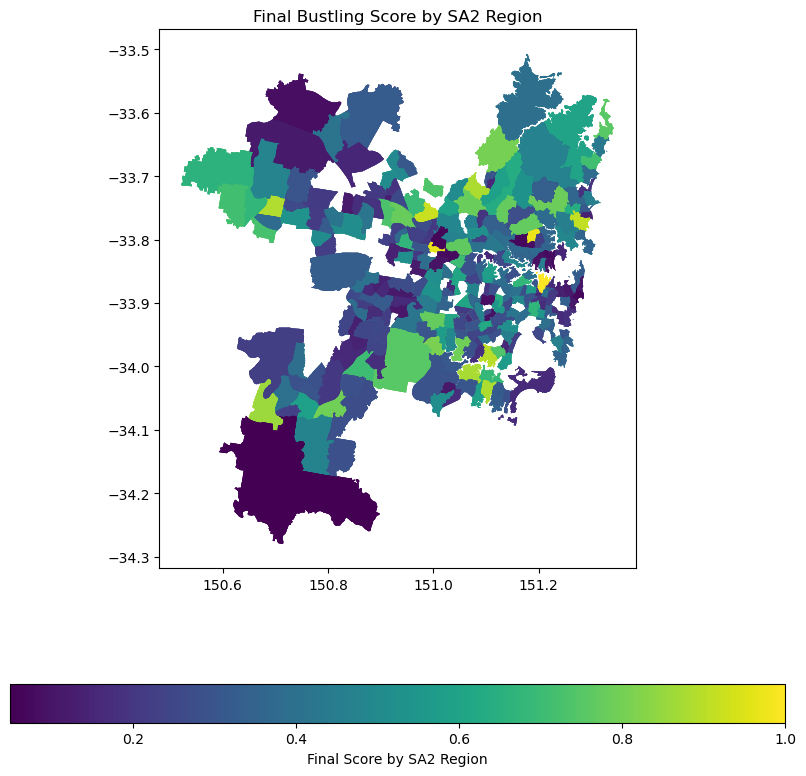

In [171]:
sql = "SELECT * FROM regions"
regions_gdf = gpd.read_postgis(sql, conn, crs=4326)

sql = "SELECT * FROM combined_final_score"
scores = pd.read_sql_query(sql, conn)

regions_gdf['sa2_code21'] = regions_gdf['sa2_code21'].astype(str)
scores['sa2_code'] = scores['sa2_code'].astype(str)

sql = "SELECT * FROM income"
income = pd.read_sql_query(sql, conn)

income['sa2_code21'] = income['sa2_code21'].astype(str)

spatial_score = regions_gdf.merge(scores, left_on='sa2_code21', right_on='sa2_code', how='inner')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

spatial_score.plot(
    column='final_score', ax=ax, legend=True,
    legend_kwds={'label': "Final Score by SA2 Region", 'orientation': "horizontal"}, cmap='viridis')

plt.title('Final Bustling Score by SA2 Region')
plt.show()

In [172]:
import matplotlib.pyplot as plt

high_score_regions = spatial_score[['sa2_code21', 'sa2_name21', 'final_score']].sort_values(by='final_score', ascending=False).drop_duplicates(subset=['sa2_name21']).head(10)
low_score_regions = spatial_score[['sa2_code21', 'sa2_name21', 'final_score']].sort_values(by='final_score').drop_duplicates(subset=['sa2_name21']).head(10)

print("Top 10 regions with highest scores:")
print(high_score_regions)

print("\nTop 10 regions with lowest scores:")
print(low_score_regions)

average_score = spatial_score['final_score'].mean()

print(f"\nOverall average score: {average_score:.2f}")



Top 10 regions with highest scores:
    sa2_code21                      sa2_name21  final_score
226  117031644  Sydney (North) - Millers Point     1.000000
157  117031645      Sydney (South) - Haymarket     0.999755
376  119021573                         Lakemba     0.994436
889  125041717              Parramatta - North     0.988106
336  119021574                      Wiley Park     0.983539
519  121011684                Chatswood - East     0.971154
80   116011303   Blacktown (East) - Kings Park     0.952205
32   115011290           Baulkham Hills - East     0.944330
368  119031374   South Hurstville - Blakehurst     0.942646
774  124031464                         Penrith     0.939305

Top 10 regions with lowest scores:
     sa2_code21                          sa2_name21  final_score
691   123031446                Douglas Park - Appin     0.049225
877   125041489                    North Parramatta     0.057121
509   121011399  Chatswood (West) - Lane Cove North     0.068110
20    11

In [173]:
income_score = income.merge(scores, left_on='sa2_code21', right_on='sa2_code', how='inner')
income_score['median_income'] = pd.to_numeric(income_score['median_income'], errors='coerce')

# Calculate correlation
incomes = income_score['median_income']
scores = income_score['final_score']

correlation = incomes.corr(scores)

print("Correlation between median_income and final_score:", correlation)

Correlation between median_income and final_score: -0.12513135354285373


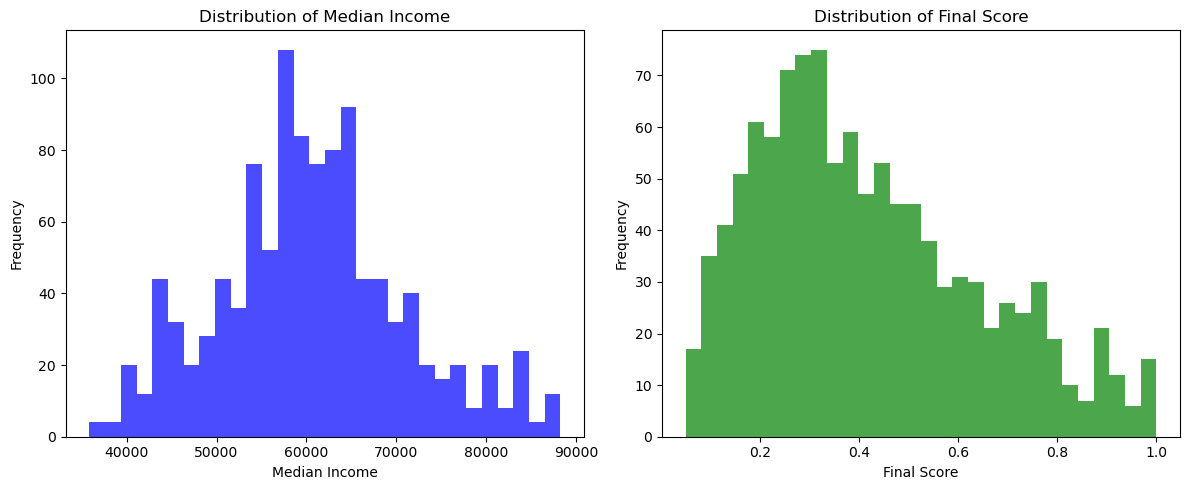

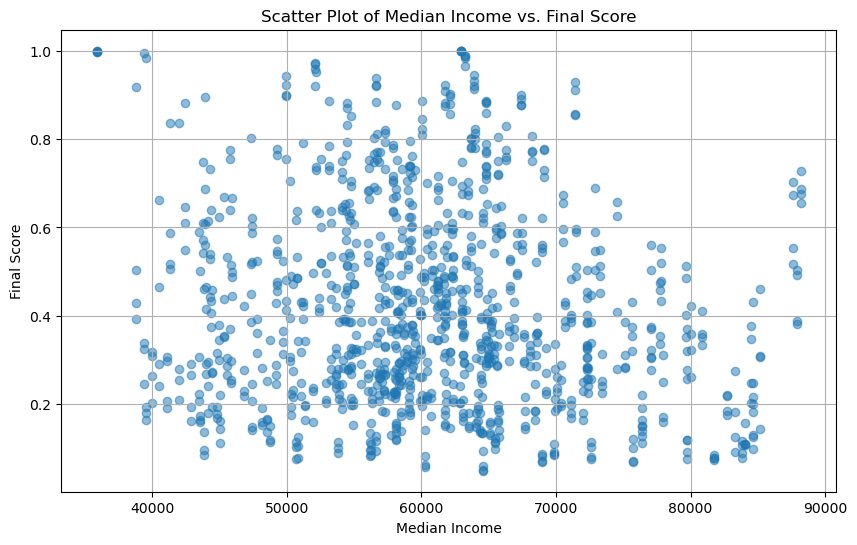

In [174]:
# Plot histograms for median income and final score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(income_score['median_income'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Median Income')
plt.xlabel('Median Income')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(income_score['final_score'].dropna(), bins=30, color='green', alpha=0.7)
plt.title('Distribution of Final Score')
plt.xlabel('Final Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot scatter plot of median income vs. final score
plt.figure(figsize=(10, 6))
plt.scatter(income_score['median_income'], income_score['final_score'], alpha=0.5)
plt.title('Scatter Plot of Median Income vs. Final Score')
plt.xlabel('Median Income')
plt.ylabel('Final Score')
plt.grid(True)
plt.show()




# End the program

In [175]:
conn.close()
db.dispose()